In [1]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [2]:
memory = MemorySaver()

search_tool = TavilySearch(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

In [3]:
class BasicState(TypedDict): 
    messages: Annotated[List, add_messages]

In [4]:
def model(state: BasicState): 
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

In [5]:
def tools_router(state: BasicState): 
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and 
    len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return "stop"

In [6]:
graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router,{
    "tools":"tools",
    "stop":END
})

graph.add_edge("tools", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

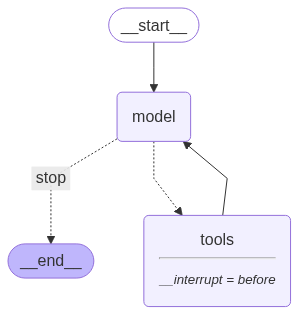

In [7]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
config = {"configurable": {
    "thread_id": 1
}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Kolkata?")]
}, config=config, stream_mode="values")

for event in events:
    # event["messages"][-1].pretty_print()
    print(event)
    for node_id, value in event.items():
        print(node_id)

{'messages': [HumanMessage(content='What is the current weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='6149262a-064a-4bbb-bbd3-8542f6351997')]}
messages
{'messages': [HumanMessage(content='What is the current weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='6149262a-064a-4bbb-bbd3-8542f6351997'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'wgq2trba8', 'function': {'arguments': '{"query":"Current weather in Kolkata","search_depth":"advanced","time_range":"day","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 1794, 'total_tokens': 1833, 'completion_time': 0.075484171, 'prompt_time': 0.120235465, 'queue_time': 1.4068246960000002, 'total_time': 0.195719636}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cfc7eb6d-9

In [10]:
snapshot = app.get_state(config=config)
snapshot.next

('tools',)

In [11]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search (wbt76e9dz)
 Call ID: wbt76e9dz
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_favicon: True
    include_images: True
    query: Current weather in Kolkata today
    search_depth: advanced
    start_date: None
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "Current weather in Kolkata today", "follow_up_questions": null, "answer": null, "images": ["https://www.financialexpress.com/wp-content/uploads/2025/03/Kolkata-Weather-IPL-2025.jpg?w=620", "https://www.sangbadpratidin.in/wp-content/uploads/2024/07/21st-july_weather.jpg", "https://static.tnn.in/thumb/msid-112303014,thumbsize-1545380,width-1280,height-720,resizemode-75/112303014.jpg", "https://static.tnn.in/thumb/msid-110815777,thumbsize-36522,width-1280,height-720,resizemode-75/110

In [14]:
for even in events:
    print(event)